In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
ab = pd.read_csv('../data/pitch/atbats.csv')

In [4]:
ab.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [5]:
# filter to only year 2018
ab2018 = ab.loc[ab.ab_id.astype(str).str.startswith('2018')]

In [6]:
names = pd.read_csv('../data/pitch/player_names.csv')

In [7]:
# join dataframes on batter id
named_ab = pd.merge(ab2018, names, left_on = 'batter_id', right_on = 'id', how = 'left')

In [8]:
# restrict to National League MVP candidates
last = ['Yelich', 'Baez', 'Arenado']
NLmvps = named_ab.loc[(named_ab.last_name.isin(last)) & (named_ab.first_name != 'Pedro')]

In [9]:
# make individual data frames
yelich = NLmvps.loc[NLmvps.last_name == 'Yelich']
baez = NLmvps.loc[NLmvps.last_name == 'Baez']
arenado = NLmvps.loc[NLmvps.last_name == 'Arenado']

In [10]:
NLmvps.event.unique()

array(['Hit By Pitch', 'Intent Walk', 'Lineout', 'Strikeout', 'Single',
       'Groundout', 'Home Run', 'Walk', 'Runner Out', 'Flyout', 'Pop Out',
       'Forceout', 'Double', 'Fielders Choice Out', 'Triple', 'Sac Fly',
       'Grounded Into DP', 'Field Error', 'Double Play', 'Strikeout - DP',
       'Bunt Groundout', 'Sac Bunt', 'Bunt Pop Out'], dtype=object)

In [11]:
# list of things categorized as 'on-base' events
on_base = ['Walk', 'Single', 'Double', 'Home Run', 'Hit By Pitch', 'Triple', 'Intent Walk']

In [12]:
# function that counts each game, i.e. a player could have 4 at bats in the same game, they all need to be labelled 
# with the same game count
def game_count(df):
    ct = [1]
    i = 1
    for j, game_id in enumerate(df.iloc[1:,3]):
        if game_id == df.iloc[j,3]:
            ct.append(i)
        else:
            i += 1
            ct.append(i)
    df['game_count'] = ct
    return df

In [13]:
# compute on base percentage, on a rolling at-bat period
def on_base_pct(df, roll):
    df['on_base_flag'] = np.where(df.event.isin(on_base), 1, 0)
    df['ob_pct'] = df.on_base_flag.rolling(roll).sum() / roll
    return df

In [14]:
# compute slugging percentage, on a rolling at-bat period
def slugging(df, roll):
    df['total_bases'] = 0
    df.loc[(df.event.isin(['Walk', 'Single', 'Hit By Pitch', 'Intent Walk'])), 'total_bases'] = 1
    df.loc[df.event == 'Double', 'total_bases'] = 2
    df.loc[df.event == 'Triple', 'total_bases'] = 3
    df.loc[df.event == 'Home Run', 'total_bases'] = 4
    df['Slugging'] = df.total_bases.rolling(roll).mean()
    return df

In [15]:
# function that creates all these new columns using helper functions above
def create_cols(df, roll):
    df = game_count(df) # create game # index
    df['ab_num'] = df.reset_index().index + 1 - roll # create ab bat index
    df = on_base_pct(df, roll) # create on base percentage over rolling n at bats
    df = slugging(df, roll)  # create slugging percentage, ie total bases / at bats
    df['obps'] = df.ob_pct + df.Slugging # create obp+s
    df = df[['first_name', 'last_name', 'game_count', 'ab_num', 'event','on_base_flag', 'ob_pct', 
             'Slugging', 'obps']] # keep only desired columns
    df = df.dropna() # drop na rows
    return df

In [16]:
# create these new columns for each player
yelich = create_cols(yelich, 50)
baez = create_cols(baez, 50)
arenado = create_cols(arenado, 50)

In [17]:
def grouping(df):
    df = df.groupby(['game_count','last_name']).agg('mean')[['ob_pct', 'Slugging', 'obps']].reset_index()
    return df

In [18]:
# group by game count
yelich = grouping(yelich)
baez = grouping(baez)
arenado = grouping(arenado)

In [19]:
# stack the individual frames, add MVP winner flag
combinedNL = pd.concat([yelich, baez, arenado])
combinedNL.loc[combinedNL.last_name == 'Yelich', 'winnerFlag'] = 'won'
combinedNL.loc[combinedNL.last_name != 'Yelich', 'winnerFlag'] = 'no'
combinedNL.head()

,game_count,last_name,ob_pct,Slugging,obps,winnerFlag
0,11,Yelich,0.420,0.620,1.040,won
1,12,Yelich,0.404,0.604,1.008,won
2,13,Yelich,0.432,0.632,1.064,won
3,14,Yelich,0.410,0.605,1.015,won
4,15,Yelich,0.345,0.525,0.870,won


In [20]:
%R -i combinedNL

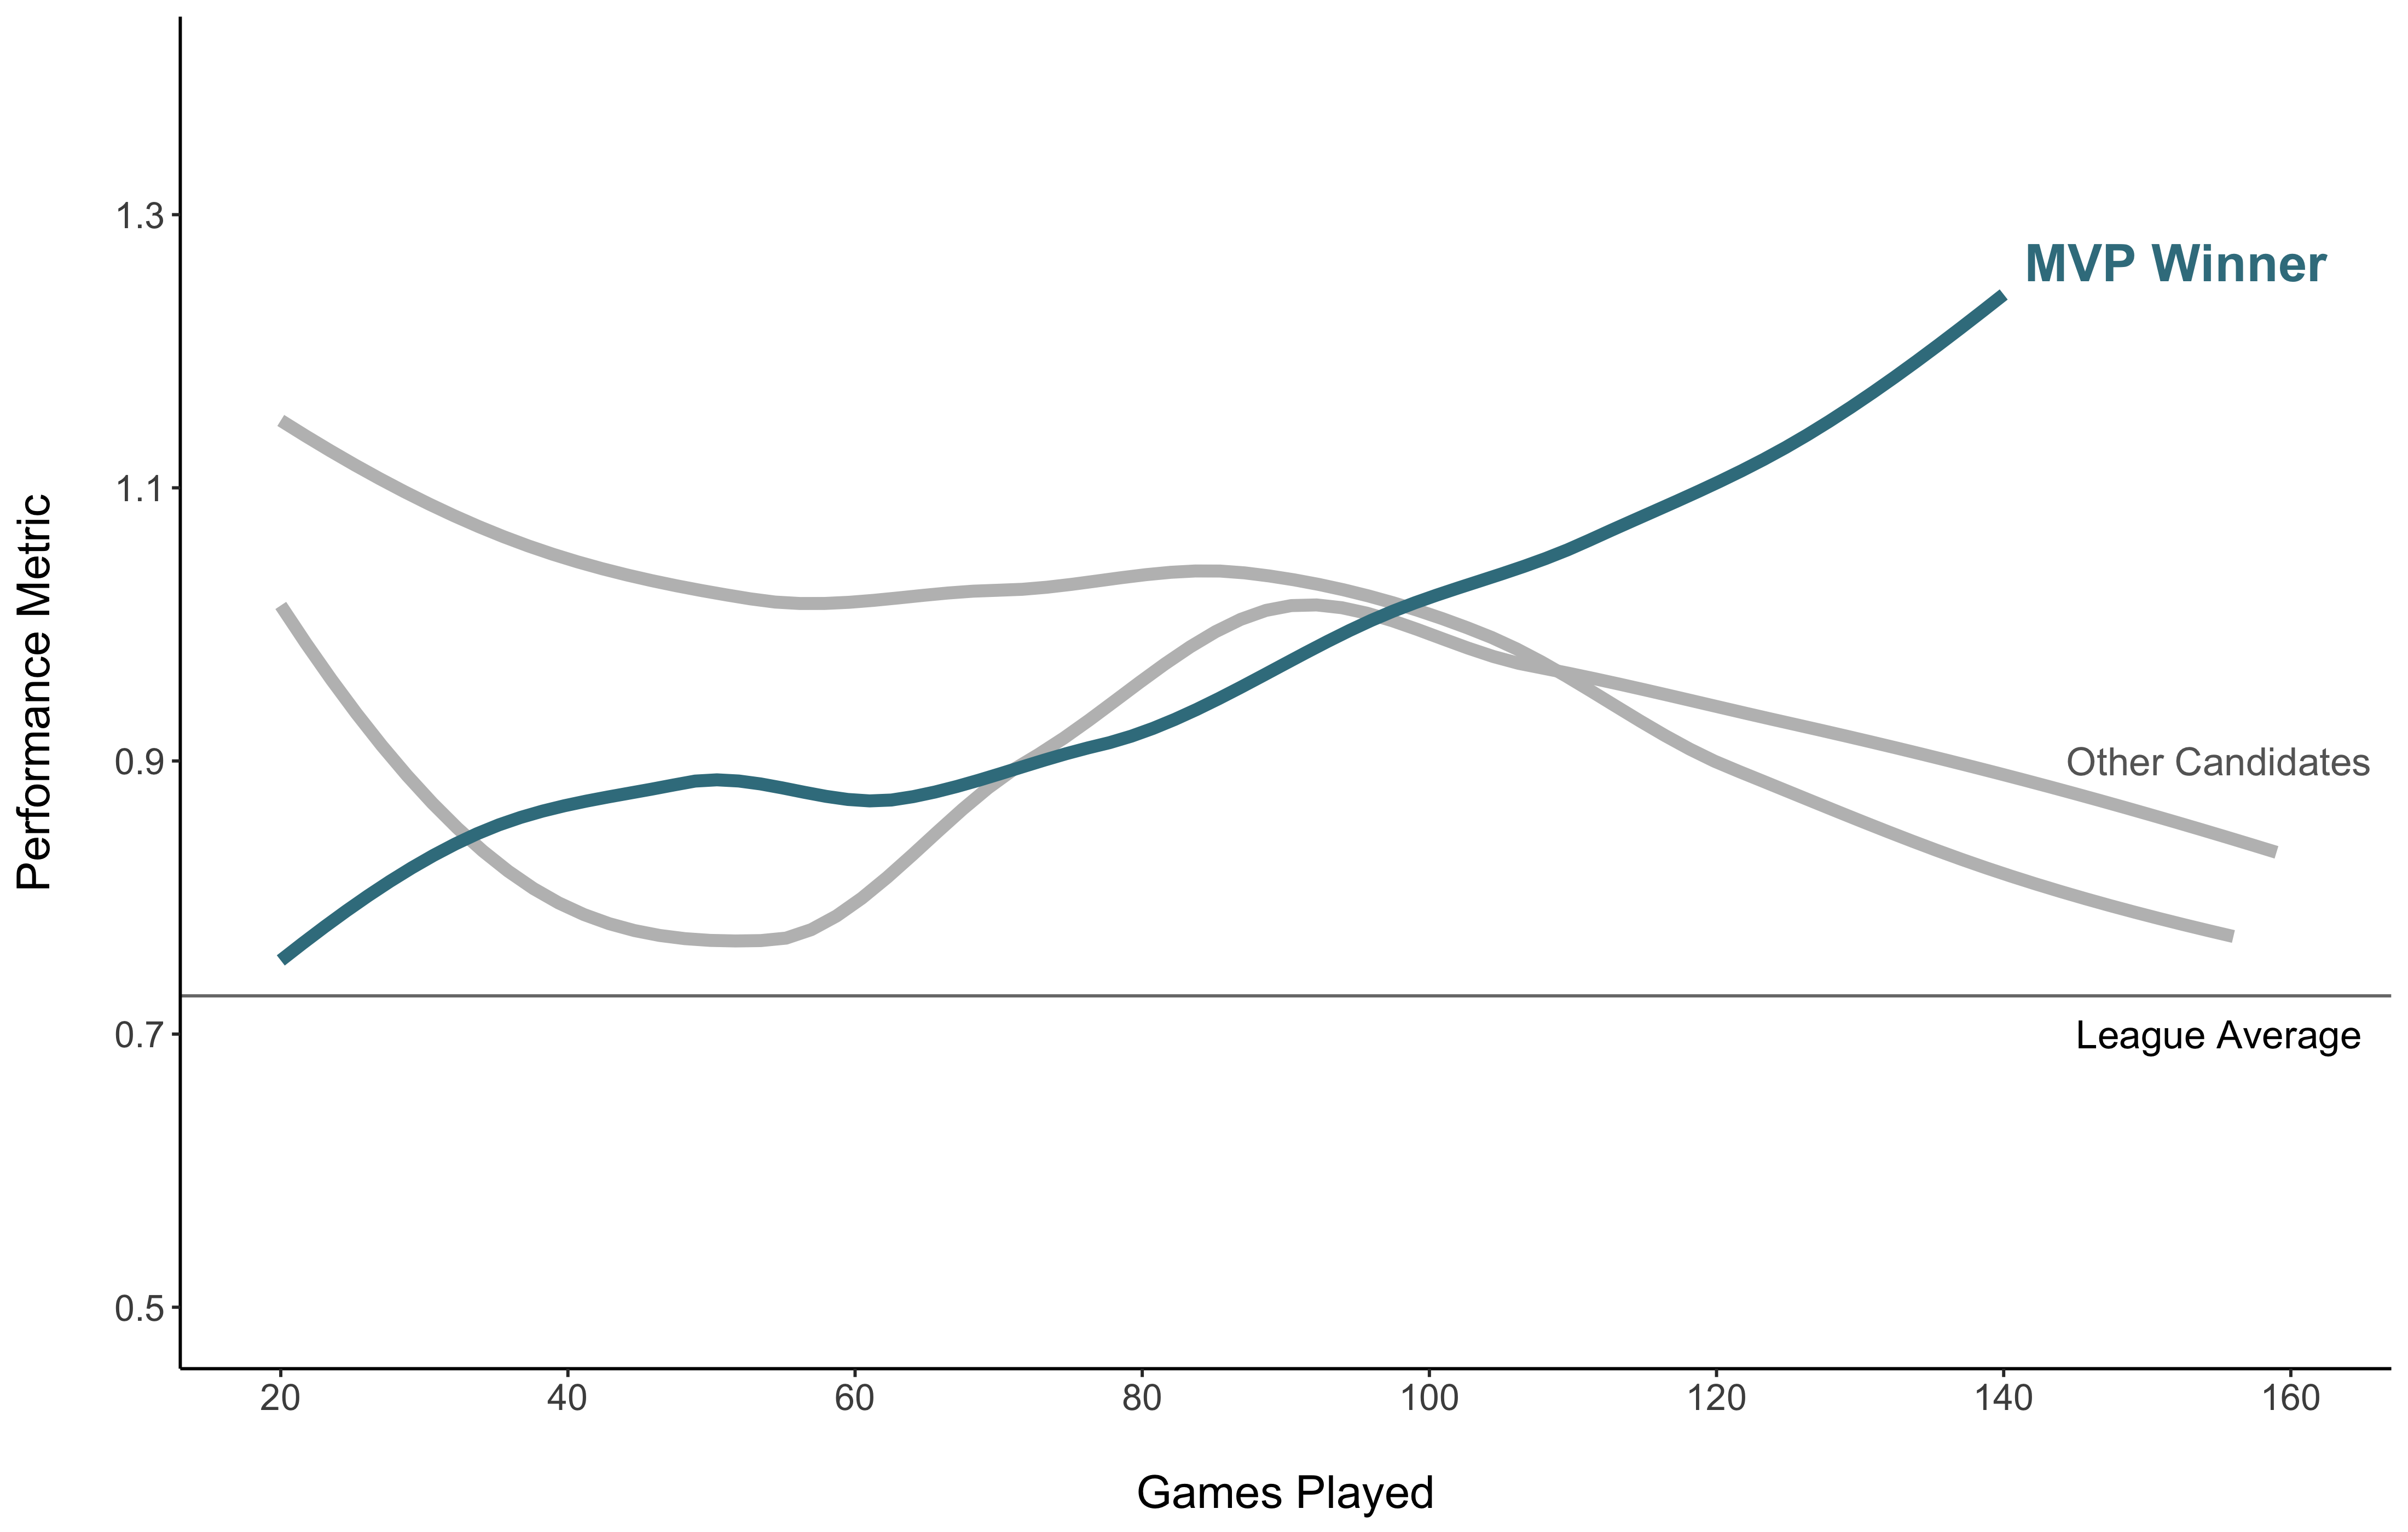

In [21]:
%%R -w 11 -h 7 --units in -r 400

ggplot() + geom_smooth(aes(x=game_count, y = obps, group = last_name, color = winnerFlag), 
                       data = combinedNL, method = 'loess', formula = 'y ~ x', se = F, size = 2) +
        geom_hline(yintercept = 0.728, alpha = 0.6) +
        annotate("text", x = 155, y = 0.7, size = 4.5, color = 'black',
                label = "League Average") +
        annotate("text", x = 155, y = 0.9, size = 4.5, color = 'grey40',
                label = "Other Candidates") +
        annotate("text", x = 152, y = 1.265, size = 6, color = '#3b7d8d',
                label = "MVP Winner", fontface = 'bold') +
        scale_color_manual(values = c('grey', '#3b7d8d')) +
        xlab('\nGames Played') +
        ylab('Performance Metric\n') +
        scale_x_continuous(limits = c(20, 160), breaks = seq(20, 160, by = 20)) +
        scale_y_continuous(limits = c(0.5, 1.4), breaks = seq(0.5, 1.4, by = 0.2)) +
        guides(color = F) +
        theme_classic() +
        theme(text = element_text(size = 15))

In [22]:
%R ggsave('../images/mvp.pdf', units = 'in', width = 11, height = 8.5, dpi = 400)